<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/EM_bayes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import pandas as pd

In [197]:
n=10
x=np.linspace(-10,10,n)
noize = np.random.normal(loc=0, scale=3,size=(n,1)).flatten()
y=10+3*x+5*x**2 + x**3
y=y+noize
df=pd.DataFrame(data=np.array([y,np.ones(len(x)), x, x**2 , x**3 ]).T, columns=["y", "const", "x", "x^2", "x^3"])
X=df[[ "const", "x", "x^2", "x^3"]]
X.head()

,const,x,x^2,x^3
0,1.0,-10.000000,100.000000,-1000.000000
1,1.0,-7.777778,60.493827,-470.507545
2,1.0,-5.555556,30.864198,-171.467764
3,1.0,-3.333333,11.111111,-37.037037
4,1.0,-1.111111,1.234568,-1.371742


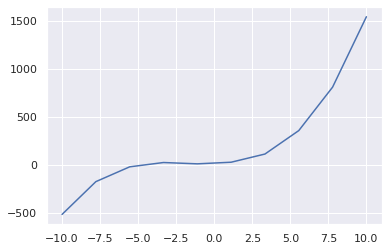

In [172]:
plt.plot(df["x"], df["y"])

In [262]:
np.dot(X.T, X).shape

(2, 2)

# Eステップ

In [0]:
class EM_bayes():
    def __init__(self,N,M):
        self.N=N
        self.M=M

    def Estep(self, x,y, a,b):
        S_N = np.linalg.inv(a*np.eye(self.M) +b *np.dot(x.T,x))
        m_N = b*np.dot(S_N ,np.dot(x.T,y))
        self.E_w= np.dot(m_N.T, m_N)+np.trace(S_N)
        self.E_t=  np.linalg.norm(y-np.dot(x, m_N),ord=2) +np.trace(np.dot(np.dot(x.T, x),S_N) )
        E=(self.M/2)*np.log(a/(2*np.pi) )-(a/2)*self.E_w +(self.N/2)*np.log(b/(2*np.pi ))-(b/2)*self.E_t
        return [self.E_w, self.E_t,E]

    def Mstep(self, x,y,a,b):
        self.a_new = self.M/self.E_w
        self.b_new = self.N/self.E_t
    
   

    def Calc(self,x,y):
        [a,b]=np.abs(np.random.randn(2))
        [_,_,self.E_old]=self.Estep(x, y, a, b)
        self.Mstep(x, y, a, b )
        [_,_,self.E_new] = self.Estep(x, y, self.a_new, self.b_new )
        count=1
        sigma=[]
        m=[]

        while (np.abs(self.E_new -self.E_old)>0.0001 ) and (count<100) :
            self.Mstep( x,y,self.a_new, self.b_new) 
            self.S_N = np.linalg.inv(self.a_new *np.eye(self.M) +self.b_new *np.dot(x.T,x))
            self.m_N = self.b_new*np.dot(self.S_N ,np.dot(x.T,y))
            #self.S_N = 1/(self.a_new +self.b_new *np.dot(x.T,x))
            #self.m_N = self.b_new*self.S_N *np.dot(x.T,y)
            sigma.append(self.S_N)
            m.append(self.m_N)
            self.E_old = self.E_new
            [_,_,self.E_new] = self.Estep(x,y,self.a_new,self.b_new )    
            count+=1 
            print("Lilelihood={}".format(self.E_new))    
        else:
            print("Convergence !")
            
        return [self.E_new, sigma,m]
                  



In [183]:
em = EM_bayes(N=n,M=len(X.columns))
[E,sigma,m]=em.Calc(X,y)
m=np.array(m).reshape(-1,4)
sigma = np.array(sigma).reshape(-1,4,4)

Lilelihood=-31.05645618401311
Lilelihood=-29.24229842454496
Lilelihood=-28.368051632637837
Lilelihood=-28.004004605395192
Lilelihood=-27.860598237653356
Lilelihood=-27.804279526829994
Lilelihood=-27.78201592550542
Lilelihood=-27.77317486466065
Lilelihood=-27.769656382517766
Lilelihood=-27.768254831312067
Lilelihood=-27.76769632571021
Lilelihood=-27.76747373216818
Lilelihood=-27.767385011624754
Convergence !


In [184]:
sigma[-1]

array([[ 2.707e-01,  2.948e-17, -3.741e-03, -3.498e-19],
       [ 2.948e-17,  1.969e-02, -5.968e-19, -2.317e-04],
       [-3.741e-03, -5.968e-19,  9.215e-05,  6.828e-21],
       [-3.498e-19, -2.317e-04,  6.828e-21,  3.203e-06]])

a_0, a_1がどのくらい早く収束しているか見る

In [0]:
np.set_printoptions(precision=3)
a_0 = m[:,0]
a_1 = m[:,1]
a_2 = m[:,2]
a_3 = m[:,3]
sig_0 = sigma[:,0,0]
sig_1 = sigma[:,1,1]
sig_2 = sigma[:,2,2]
sig_3 = sigma[:,3,3]

In [176]:
print("a_0 sequence is {}".format(a_0)) 
print("a_1 sequence is {}".format(a_1)) 

a_0 sequence is [9.986 9.983 9.982 9.982 9.981 9.981 9.981 9.981 9.981 9.981]
a_1 sequence is [2.836 2.836 2.836 2.836 2.836 2.836 2.836 2.836 2.836 2.836]


EMアルゴリズム一回で殆ど終わっていますね。希望としては、iterationが進むにつれて、平均が動き、分散が小さくなってくれているとそれっぽさがあります。

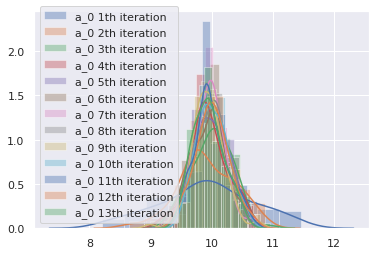

In [204]:
for i in range(len(a_0)):
    sns.distplot(np.random.normal(loc=a_0[i], scale=sig_0[i],size=(100,1)),label="a_0 {}th iteration".format(i+1) )
plt.legend()    
plt.savefig("a_0dist.png")

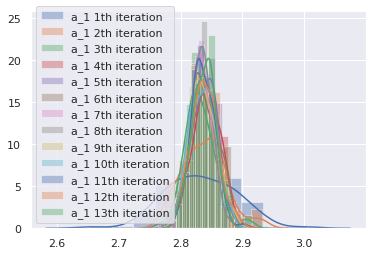

In [206]:
for i in range(len(a_1)):
    sns.distplot(np.random.normal(loc=a_1[i], scale=sig_1[i],size=(100,1)),label="a_1 {}th iteration".format(i+1) )
plt.legend()    
plt.savefig("a_1dist.png")

何回か計算しなおすと、希望通りの結果が出ます。出来た確率分布から定数をサンプリングして曲線を描いてみます。

In [0]:
[[a_0, a_1, a_2, a_3]] =np.random.multivariate_normal(mean=m[-1], cov=sigma[-1],size=1)

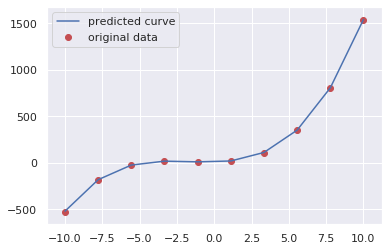

In [201]:
Y=a_0+a_1*x + a_2*x**2 + a_3*x**3
plt.plot(x,Y, label="predicted curve")
plt.scatter(x,y, label="original data", c="r")
plt.legend()
plt.savefig("predict.png")

計算させた感はありませんが、良い感じに予測はしてくれました。